# Homework 1
***

We are going to work with the following dataset: fluid current in a tube.
Some statistics are collected for dataset, incl. mean, skewness, kurtosis, etc. We are predicting flow rate ('tohn/hour'). We need to build confidence and predictive intervals.

In [ ]:
!wget https://raw.githubusercontent.com/dmkovalev/hamc2023/main/homeworks/exxsol_data.csv

--2023-04-10 20:57:16--  https://raw.githubusercontent.com/dmkovalev/hamc2023/main/homeworks/exxsol_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84661 (83K) [text/plain]
Saving to: ‘exxsol_data.csv’

exxsol_data.csv     100%[===================>]  82.68K  --.-KB/s    in 0.009s  

2023-04-10 20:57:16 (9.23 MB/s) - ‘exxsol_data.csv’ saved [84661/84661]



In [ ]:
%matplotlib inline

import numpy as np
from sklearn import datasets, linear_model, preprocessing, model_selection
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv('exxsol_data.csv', sep=';', header=(0))

There are 10 features and 1 label to predict:

In [ ]:
print(df.columns.values)

['mean' 'std' 'skew' 'kurt' 'RMS' 'crest' 'freq_peak' 'shan' 'perm' 'temp'
 'tohn/hour']


In [ ]:
y = df['tohn/hour']
freq_temp = df[['freq_peak','temp']]

Physics tells us that flow rate is a function of a frequency peak and temperature.

In [ ]:
freq_temp, y = shuffle(freq_temp, y)

# split data into training and testing sets
#from sklearn.model_selection import train_test_split
#train_freq, test_freq, train_y, test_y = train_test_split(freq, y, train_size=0.7, random_state=2)

lr = linear_model.LinearRegression()
predicted = model_selection.cross_val_predict(
    lr, freq_temp, y.ravel(), cv=20)
score = model_selection.cross_val_score(lr, freq_temp, y,
                                         scoring='r2',cv=20)

## Q0: Build point estimate for mean r2 score and its deviation

In [ ]:
score.mean(), score.std()

(0.8210374227015922, 0.08995255507464928)

## Q1: Predicted is an array with predictions of the label y. Assuming, that $\sigma = 0.1$, compute 95% confidence and predictive interval for mean squared error. 

In [ ]:
e = np.sqrt((y - predicted) ** 2)

In [ ]:
import numpy as np, scipy.stats as st

ci = st.t.interval(0.95, len(e) - 1, loc=np.mean(e), scale=0.1)
pi = st.t.interval(0.95, len(e) - 1, loc=np.mean(e), scale=0.1 * (1 + 1 / len(e)))

print(ci)
print(pi)

(0.12560304417691642, 0.5182757593611014)
(0.12532256366607059, 0.5185562398719472)


## Q2:  Compute 95% confidence and predicted intervals for mean squared error, assuming no knowledge about $\sigma$.

In [ ]:
ci = st.t.interval(0.95, len(e) - 1, loc=np.mean(e), scale=e.std())
pi = st.t.interval(0.95, len(e) - 1, loc=np.mean(e), scale=e.std() * (1 + 1 / len(e)))

print(ci)
print(pi)

(-0.15824007998457296, 0.8021188835225908)
(-0.1589260506727923, 0.8028048542108102)


We can use additional features and more complex model, e.g. ElasticNet.

In [ ]:
y = df['tohn/hour']
X = df.drop(['tohn/hour'],axis=1)
X = preprocessing.scale(X)
X, y = shuffle(X, y)

encv = linear_model.ElasticNetCV(cv=10,max_iter=3000, n_alphas=10)
predicted_encv = model_selection.cross_val_predict(
    encv, X, y.ravel(), cv=20)
score_encv = model_selection.cross_val_score(encv,X, y.ravel(),
                                         scoring='r2',cv=20)

## Q3:  Compute 95% confidence interval for difference in means of mean squared error between 2 models, assuming no knowledge about $\sigma$.

In [ ]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [ ]:
e = np.sqrt((y - predicted) ** 2) 
e_encv = np.sqrt((y - predicted_encv) ** 2) 


n,m = len(e), len(e_encv)
X_mean, Y_mean = np.mean(e), np.mean(e_encv)
S_X, S_Y = np.var(e, ddof=1), np.var(e_encv, ddof=1)
S_P = ((n-1) * S_X + (m-1) * S_Y) / (n + m - 2)


_tconfint_generic(X_mean - Y_mean, 
                  np.sqrt(S_P), n + m - 2, 0.05, 'two-sided')


(-0.16021593104402942, 2.0398988351534237)

## Q4: Implement UCB1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


class Model:
    def __init__(self, probability, init_mean=0):
        self.probability = probability
        self.mean = init_mean
        if init_mean > 0:
             self.sample_size = 1
        else:
             self.sample_size = 0
    
    def execute(self):
        return np.random.uniform(0,1) < self.probability

    def update(self, x):
        self.sample_size += 1
        self.mean = ((self.sample_size - 1)*self.mean + x) / self.sample_size


def experiment(model_probs, eps, total=1000):
    models = [Model(p, init_mean=0) for p in model_probs]
    rewards = np.zeros(total)

    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0

    optimal_j = np.argmax([m.probability for m in models])
    print("optimal j:", optimal_j)

    for i in range(total):

      # use epsilon-greedy to select the best
      if np.random.uniform(0,1) < eps:
        num_times_explored += 1
        j = np.random.randint(len(models))
      else:
        num_times_exploited += 1
        j = np.argmax([m.mean + np.sqrt(2 * np.log(i) / m.sample_size) for m in models])

      if j == optimal_j:
        num_optimal += 1

      # execute best model
      x = models[j].execute()

      # update rewards 
      rewards[i] = x

      # update the distribution for the executed model
      models[j].update(x)
      
    for m in models:
      print("mean estimate:", m.mean)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / total)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(total) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(total)*np.max(model_probs))
    plt.show()

optimal j: 2


<ipython-input-18-ef3fd0cf534f>:42: RuntimeWarning: divide by zero encountered in log
  j = np.argmax([m.mean + np.sqrt(2 * np.log(i) / m.sample_size) for m in models])
<ipython-input-18-ef3fd0cf534f>:42: RuntimeWarning: invalid value encountered in sqrt
  j = np.argmax([m.mean + np.sqrt(2 * np.log(i) / m.sample_size) for m in models])
<ipython-input-18-ef3fd0cf534f>:42: RuntimeWarning: invalid value encountered in double_scalars
  j = np.argmax([m.mean + np.sqrt(2 * np.log(i) / m.sample_size) for m in models])
<ipython-input-18-ef3fd0cf534f>:42: RuntimeWarning: divide by zero encountered in double_scalars
  j = np.argmax([m.mean + np.sqrt(2 * np.log(i) / m.sample_size) for m in models])


mean estimate: 0.25000000000000006
mean estimate: 0.4383561643835616
mean estimate: 0.7512768130745662
total reward earned: 7435.0
overall win rate: 0.7435
num_times_explored: 0
num_times_exploited: 10000
num times selected optimal bandit: 9790


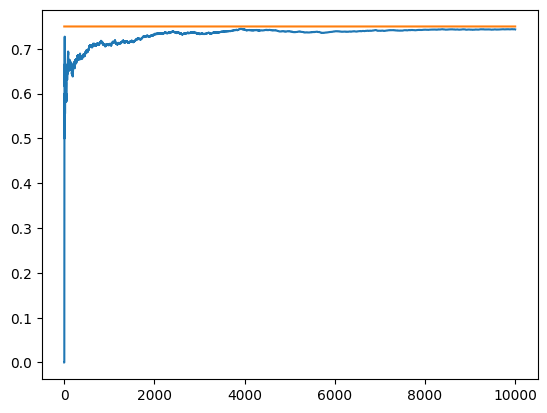

In [ ]:
total = 10000
eps = 0
model_probs = [0.2, 0.5, 0.75]
experiment(model_probs, eps, total)